In [1]:
#import necessary modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import os, glob

import warnings
warnings.filterwarnings('ignore')

#%matplotlib notebook

In [2]:
#set initial path
#path = os.getcwd()

In [3]:
#search for files
def get_file_paths(district):
    path_list = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.find('豐原') != -1 and file.endswith(".csv"):
                path_list.append(os.path.join(root, file))
            elif file.find('豐原') != -1 and file.endswith(".xls"):
                path_list.append(os.path.join(root, file))
    return path_list

In [26]:
#get_file_paths('豐原')

In [5]:
#load csv and xls files into pandas DataFrame
def load_data(path_list):
    files = {}
    column_format = ['日期', '測站','測項','1','2','3','4','5','6','7','8','9','10',
                    '11','12','13','14','15','16','17','18','19','20',
                    '21','22','23','24']
    
    for i in range(len(path_list)):
        if path_list[i][-3:] == 'csv':
            files['file'+str(i)] = pd.read_csv(path_list[i], encoding = 'big5')
            files['file'+str(i)].columns = column_format
        else:
            files['file'+str(i)] = pd.read_excel(path_list[i], encoding = 'big5')
            files['file'+str(i)].columns = column_format
            
    return files

In [6]:
#load_data(get_file_paths('豐原'))

目前看起來所有年度資料集均是一樣的資料格式（27欄：日期，測站，測項，當日1~24時）

可以直接執行資料集組合

In [10]:
#files = load_data(get_file_paths('豐原'))
#files['file0'].append(files['file1']) #csv and excel have different column formats

In [8]:
def data_combination(files):
    '''
    files - dict which stores DataFrame of each year, keys are 'file' + str(integer), values are pd.DataFrame
    return - a combined df
    '''
    df = files['file0']
    for i in range(1, len(files)):
        df = df.append(files['file' + str(i)])
        
    return df

Done. EASY!

In [11]:
#df = data_combination(files)
#df.dtypes

#pd.to_datetime(files['日期'])
#fail to implement astype(datetime64)

在執行資料型態轉換之前，應先確認資料結構是否均與我們預想的一致（1~24時資料應為NaN or float，不應出現str type）

In [51]:
#'1.0001'.isnumeric() #False
#'1.0001'.isdigit() #False
#'1.0001'.isdecimal() #False

In [12]:
def max_picker(df):
    df['max'] = df.loc[:, [str(i) for i in range(1,25)]].max(axis = 1)
    return df['max']

In [13]:
def change_dtypes(df):
    '''
    The data of each column are all object/str, should be replaced with appropriate dtypes
    such as Datetime, float, and string.
    
    Also, we want to know if there are NaN values or not matched dtype
    str items can not switch to float directly
    
    return - df
    '''

    # try to convert str data into float
    for i in range(1,25):
        df[str(i)] = pd.to_numeric(df[str(i)], errors = 'coerce', downcast = 'float')
    
    #print(df.dtypes)
    
    #convert date to datetime dtype
    df['日期'] = pd.to_datetime(df['日期'])
    #many detecting items we don't really need, should be filtered out
    df['max'] = max_picker(df)
    #choose PM10 to output
    pm10_df = df.loc[df['測項'] == 'PM10', ['日期', 'max']]
    #choose PM2.5 to output
    pm25_df = df.loc[df['測項'] == 'PM2.5', ['日期', 'max']]
    
    return pm10_df.sort_values(by = '日期').set_index('日期'), pm25_df.sort_values(by = '日期').set_index('日期')

In [14]:
pm10_df, pm25_df = change_dtypes(df)

完成，由此可見整個合併資料中約有10%的監測資料被人為刪除或因儀器問題遺失，但此分析不擬對此深究原因。

接下來，對資料集針對日期執行排序，由2010依序排至2016

完成後，確認測項有哪些，並找出我們感興趣的項目。

In [15]:
#pm10_df.head()

決定針對PM2.5及PM10進行視覺化，視覺化的值選取擬先採用每日最高小時值作為當日視覺化峰值。

值得注意的是PM10及PM2.5經過整理後仍有缺值的情形（一整天都沒偵測到任何數值，可能是機器故障或其他原因）。

擬於視覺化整年走向趨勢時以當月峰值中位數代替，如當日資料完全漏失（連NaN都不會顯示），也擬採用相同處理方式。

In [16]:
#get year and month info
def year_month_creater(df):
    df['year'] = pd.DatetimeIndex(df.index).year
    df['dayofyear'] = df.index.dayofyear
    df['month'] = pd.DatetimeIndex(df.index).month
    return df['year'], df['dayofyear'], df['month']

#pm10_df['year'], pm10_df['dayofyear'], df['month'] = year_month_creater(pm10_df)
#pm25_df['year'], pm25_df['dayofyear'], df['month'] = year_month_creater(pm25_df)

In [17]:
#pm10_df.head()
#for i in pm10_df['year'].unique():
#    print(len(pm10_df[pm10_df['year'] == i]))

,max,year,dayofyear,month
日期,,,,
2010-01-01,104.0,2010,1,1
2010-01-02,97.0,2010,2,1
2010-01-03,138.0,2010,3,1
2010-01-04,188.0,2010,4,1
2010-01-05,97.0,2010,5,1


日期不一致

    2010: 365
    2011: 365
    2012: 359
    2013: 344
    2014: 365
    2015: 365
    2016: 366

擬將缺值對照至當月中位數

另資料庫不分年份在視覺化組合上較為困難，擬將其拆分為單獨年份資料。

In [18]:
#how to manipulate date addition
#new_date = pm10_df.iloc[0,:].name + pd.DateOffset(1)


In [19]:
#pm10_df['dayofyear'].unique()

In [27]:
def year_spliter(df):
    df_dict = dict()
    for i in range(2010, 2017):
        df_dict['df_' + str(i)] = df.loc[df['year'] == i, ['max', 'dayofyear', 'month']]
        #run days_checker
        df_dict['df_' + str(i)] = days_null_checker(df_dict['df_' + str(i)])
    
    return df_dict

def days_null_checker(df):
    
    # set all days of year to be 365
    day_num = 365
    
    #if no data missing and no NaN values: return the original df
    if len(df) >= day_num and df['max'].isnull().sum() == 0: return df
    
    #deal with NaN values first
    if df['max'].isnull().sum() == 0: pass
    else: 
        for i in range(1, 13):
            df.loc[(df['max'].isnull() == 1) & (df['month'] == i), ['max']] = df[df['month'] == i]['max'].median()
    
    #now deal with missing dates
    if len(df) < day_num:
        days = [i for i in range(1,366)]
        unique_days = df['dayofyear'].unique().tolist()
    
        while unique_days != [] and days != []:
            if unique_days[0] == days[0]:
                days.pop(0)
                unique_days.pop(0)
            else:
                to_append = df.iloc[days[0],:]
                to_append.name = to_append.name + pd.DateOffset(1)
                to_append['dayofyear'] += 1
                df = df.append(to_append)
                days.pop(0)
                #print(to_append, len(df))
    return df.sort_values(by = 'dayofyear')

In [21]:
#pm10_2010, pm10_2011, pm10_2012, pm10_2013, pm10_2014, pm10_2015, pm10_2016 = year_spliter(pm10_df)

In [22]:
#pm25_2010, pm25_2011, pm25_2012, pm25_2013, pm25_2014, pm25_2015, pm25_2016 = year_spliter(pm25_df)

In [23]:
#len(pm10_2012), len(pm10_2013) #done!

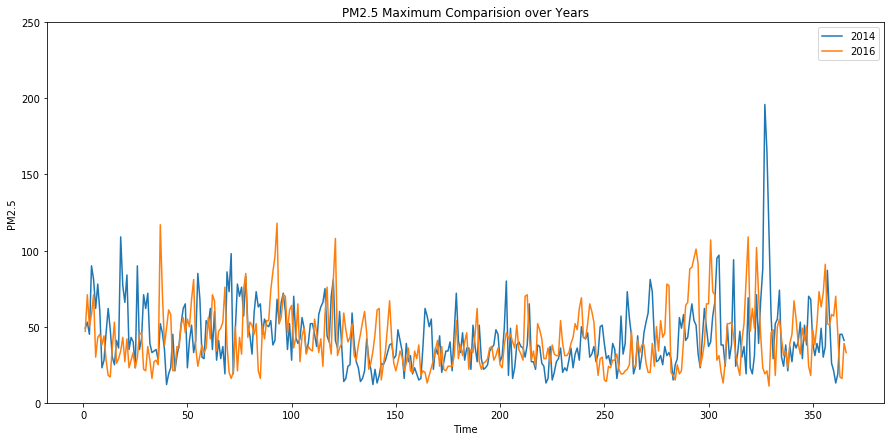

In [32]:
fig, axes = plt.subplots(figsize = (15, 7))
#axes.plot(pm25_2010['dayofyear'], pm25_2010['max'], label='2010')
#axes.plot(pm10_2011['dayofyear'], pm10_2011['max'], label='2011')
#axes.plot(pm10_2012['dayofyear'], pm10_2012['max'], label='2012')
#axes.plot(pm10_2013['dayofyear'], pm10_2013['max'], label='2013')
axes.plot(pm25_2014['dayofyear'], pm25_2014['max'], label='2014')
#axes.plot(pm10_2015['dayofyear'], pm10_2015['max'], label='2015')
axes.plot(pm25_2016['dayofyear'], pm25_2016['max'], label='2016')

axes.set(xlabel='Time', ylabel='PM2.5',
       title='PM2.5 Maximum Comparision over Years')
axes.set_ylim((0, 250))
axes.legend()

In [37]:
def put_all_together(input_dict):
    '''
    input_dict should contain 3 key-value pairs:
        1. district: the district we wanna look into
        2. checked_data: PM10 or PM2.5
        3. checked_years: a list contain 2 years data
    '''
    #get current path
    path = os.getcwd()
    #get paths list
    path_list = get_file_paths(input_dict['district'])
    #get df_dict
    files = load_data(path_list)
    #combine all df
    df = data_combination(files)
    #create df['max'] column
    df['max'] = max_picker(df)
    #create pm10 and pm2.5 df
    pm10_df, pm25_df = change_dtypes(df)
    
    #create year, dayofyear, month columns
    #split datasets by year
    if input_dict['checked_data'] == 'PM10':
        pm10_df['year'], pm10_df['dayofyear'], df['month'] = year_month_creater(pm10_df)
        df_dict = year_spliter(pm10_df)
    elif input_dict['checked_data'] == 'PM2.5':
        pm25_df['year'], pm25_df['dayofyear'], df['month'] = year_month_creater(pm25_df)
        df_dict = year_spliter(pm25_df)
    else:
        raise KeyError('The data you are looking into should be PM10 or PM2.5.')
    
    #plotting 
    fig, axes = plt.subplots(figsize = (15, 7))
    
    for i in input_dict['checked_years']:
        axes.plot(df_dict['df_' + str(i)]['dayofyear'], df_dict['df_' + str(i)]['max'], label= str(i))
    
    axes.set(xlabel='Time', ylabel = input_dict['checked_data'],
       title='{0} Maximum Comparision over Years'.format(input_dict['checked_data']))
    if input_dict['checked_data'] == 'PM10':
        axes.set_ylim((0, 250))
    elif input_dict['checked_data'] == 'PM2.5':
        axes.set_ylim((0, 150))
    axes.legend()

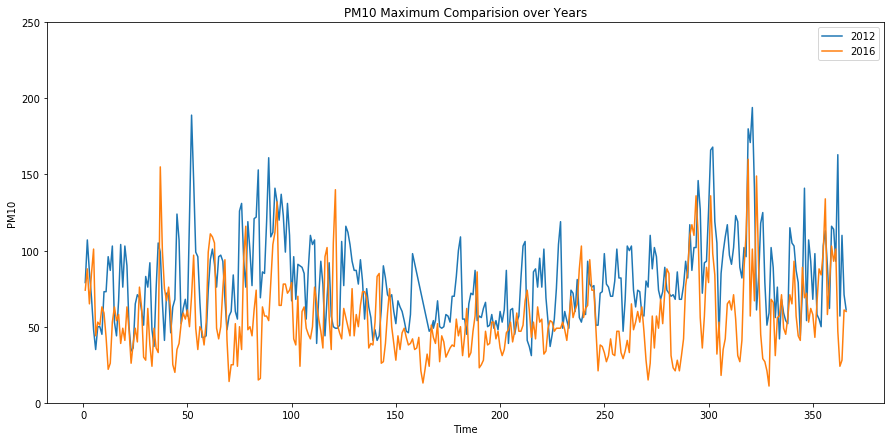

In [39]:
input_dict = {'district': '豐原', 'checked_data': 'PM10', 'checked_years': [2012,2016]}
put_all_together(input_dict)

In [40]:
def input_creator():
    input_dict = dict()
    input_dict['district'] = input('請輸入欲查詢地區')
    input_dict['checked_data'] = input('請輸入欲查詢資料，限PM10或PM2.5')
    input_dict['checked_years'] = []
    input_dict['checked_years'].append(int(input('請輸入欲查詢年度(1)(限2010~2016)')))
    input_dict['checked_years'].append(int(input('請輸入欲查詢年度(2)(限2010~2016)')))
    return input_dict

請輸入欲查詢地區萬華
請輸入欲查詢資料，限PM10或PM2.5PM2.5
請輸入欲查詢年度(1)(限2010~2016)2012
請輸入欲查詢年度(2)(限2010~2016)2016


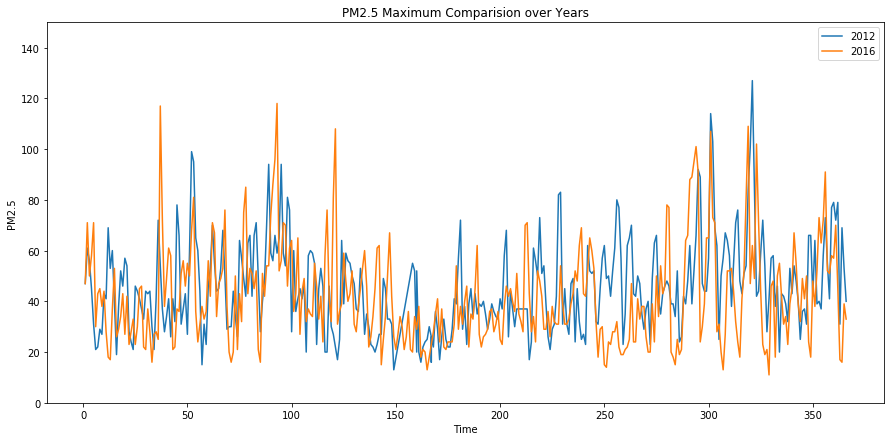

In [41]:
input_dict_1 = input_creator()
put_all_together(input_dict_1)